In [ ]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway

# Enriching (extra)
from tqdm import tqdm # Progress bar for the script
from datetime import datetime # Used for dates 
import os # Used for loading the .env file

# NLP (extra)
import re
import json
import nltk
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud

# Natural language processing

In this section we have attempted to process the summaries in a way that could cluster the movies depending on words used in the summaries themselves. 
Some of the processes take a long time to run so in the code there are multiple data sets or lists being saved as files to avoid running computational heavy tasks multiple times. 

In [ ]:
# CHECK BEFORE RUNNING!!!
flag_preprocess = False # If false, skip the generation of a preprocessed corpus
flag_cluster_labels_kmeans = False # Run the kmeans algorithm and return labels for every movie 
flag_movie_cluster = False # If false, stop overwrite of a cluster matrix
flag_best_k = False # Runs a simulation to make silhouettes of a set number of k's for kmeans algorithm 
flag_best_component = False # Runs test to find a lower bound for amount of components
flag_reduced = False # Runs the TF/IDF compression 

### Load and filter movie data

In [ ]:
# Read main data file 'movie_metadata_TMDB.csv'
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')

# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]


### Preprocess the summaries 

In [ ]:
# Preprocess the summaries and stemming
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Apply stemming and lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    return ' '.join(words)


# Remove names form the summaries
nlp = spacy.load("en_core_web_sm")

def remove_names(text): 
    doc = nlp(text)
    filtered_text = []
    for token in doc:
        if token.ent_type_ != "PERSON":
            filtered_text.append(token.text)
    return " ".join(filtered_text)

In [ ]:
# Preprocess the summaries 
preprocessed_summaries = []
if flag_preprocess:
    for summary in tqdm(filtered_summaries, desc="Processing summaries"):
        preprocessed_summaries.append(preprocess_text(remove_names(summary.split('\t')[1])))
    
    # Save preprocessed_summaries list to a file
    with open('nlp/preprocessed_summaries.pkl', 'wb') as file:
        pickle.dump(preprocessed_summaries, file)

In [ ]:
# Combined stemmed summaries with labels 
if flag_preprocess:
    summaries_preprocessed_dist = []
    for i in range(len(preprocessed_summaries)):
        summaries_preprocessed_dist.append({"id": movie_ids[i], "text": preprocessed_summaries[i]})
    
    # Save summaries_preprocessed_dist to a file
    with open('summaries_preprocessed_dist.json', 'w') as f:
        json.dump(summaries_preprocessed_dist, f)

## TF/IDF vectorization & k-means

In [ ]:
# Load preprocessed_summaries list from the saved file
with open('nlp/preprocessed_summaries.pkl', 'rb') as file:
    preprocessed_summaries = pickle.load(file)

In [ ]:
# Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_summaries)

Now we will determine the optimal number of components (n_components) for dimensionality reduction using Truncated Singular Value Decomposition (Truncated SVD) by plotting the explained variance ratio against a range of specified values for n_components and identifying a point where a sufficient amount of variance is retained.

In [ ]:
if flag_best_component:  
    # Specify a range of n_components to try
    components_range = np.arange(5000, 6001, 500)
    
    # List to store explained variance ratios
    explained_variances = []
    
    for n_components in tqdm(components_range):
        # Apply Truncated SVD
        svd = TruncatedSVD(n_components=n_components)
        tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
        
        # Calculate explained variance ratio
        explained_variance = np.sum(svd.explained_variance_ratio_)
        explained_variances.append(explained_variance)
    
    # Plot the explained variance ratio as a function of n_components
    plt.plot(components_range, explained_variances, marker='o')
    plt.title('Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

We see that with 5500 components we get above an EVR of 95%.

In [ ]:
if flag_reduced:
    # Apply Truncated SVD for dimensionality reduction
    n_components = 5500  
    svd = TruncatedSVD(n_components=n_components)
    tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

### Finding the optimal k

In [ ]:
if flag_best_k:
    silhouettes = []
    sse = []
    # Try multiple k
    for k in tqdm(range(20, 40)):
        # Cluster the data and assigne the labels
        labels = kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(tfidf_matrix_reduced) 
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(tfidf_matrix_reduced) 
        sse.append({"k": k, "sse": kmeans.inertia_})
        # Get the Silhouette score
        score = silhouette_score(tfidf_matrix_reduced, labels)
        silhouettes.append({"k": k, "score": score})

In [ ]:
if flag_best_k:   
    # Convert to dataframe
    silhouettes = pd.DataFrame(silhouettes)
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(silhouettes.k, silhouettes.score)
    plt.xlabel("K")
    plt.ylabel("Silhouette score") 

Negative values... Something is off. We have not been able to identify the problem for now.

In [ ]:
if flag_best_k:
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

There is no obvious "elbow" to be seen. We choose to go with 30 clusters and see what we get.

### Apply K-means clustering 

In [1821]:
# Apply KMeans clustering and return the labels for every movie 
num_clusters = 30 # k 

if flag_cluster_labels_kmeans: 
    cluster_labels = KMeans(n_clusters=num_clusters, n_init=20, random_state=3).fit_predict(tfidf_matrix_reduced) # This takes quite some time...
    # 10 is nice 
    # Save cluster_labels to a file
    with open('nlp/cluster_labels.pkl', 'wb') as f:
        pickle.dump(cluster_labels, f)


In [1822]:
# Load cluster_labels from a file
with open('nlp/cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [1823]:
# Create a dictionary to store movie IDs and their corresponding cluster labels
movie_clusters_id = dict(zip(movie_ids, cluster_labels))

With the movies given a cluster label we make a dataframe with all the movies in the given dataframe. For easy readability the movie ids are replaced with their actual name. 

In [1824]:
# Create a DataFrame to store cluster information
cluster_df = pd.DataFrame(columns=[f'Cluster {i}' for i in range(num_clusters)])

# Iterate through movie clusters and match with movie_metadata
if flag_movie_cluster:
    for movie_id, cluster_label in tqdm(movie_clusters_id.items()):
        # Find the corresponding row in movie_metadata based on Wikipedia Movie ID
        movie_row = movie_metadata[movie_metadata['Wikipedia Movie ID'] == movie_id]
        
        # Extract movie name from the row
        movie_name = movie_row['Movie name'].values[0] if not movie_row.empty else f'Movie {movie_id}'
        
        # Update cluster_df with movie name in the appropriate cluster column
        cluster_df.loc[len(cluster_df), f'Cluster {cluster_label}'] = movie_name
    
    
    # Fill NaN values with empty string for better representation
    cluster_df.fillna('', inplace=True)

100%|██████████| 7563/7563 [00:10<00:00, 744.31it/s] 


In [1825]:
# Save cluster_df as CSV
if flag_movie_cluster:
    cluster_df.to_csv('nlp/clustered_movies.csv', index=True)

In [1826]:
# Load cluster_df from a file
cluster_df = pd.read_csv('nlp/clustered_movies.csv')
cluster_df['Cluster 6'].sort_values().head(10)

1780                         11-11-11
684            A Month in the Country
5429                  Almost an Angel
2110                          Amadeus
6995    Amityville II: The Possession
723                 Angels and Demons
7051                        Bedazzled
735                    Ben and Arthur
931                   Beyond the Door
3991               Breaking the Waves
Name: Cluster 6, dtype: object

Looking at the titles in Cluster 6 as printed above, it looks as if our method at least clusters movies about similar topics.

## Visualizing word in clusters
In the following segment we try to look at the clusters and see if there seems to be any relevant information to be found in them. 
Firstly we will visualize the clusters in "Word Clouds".

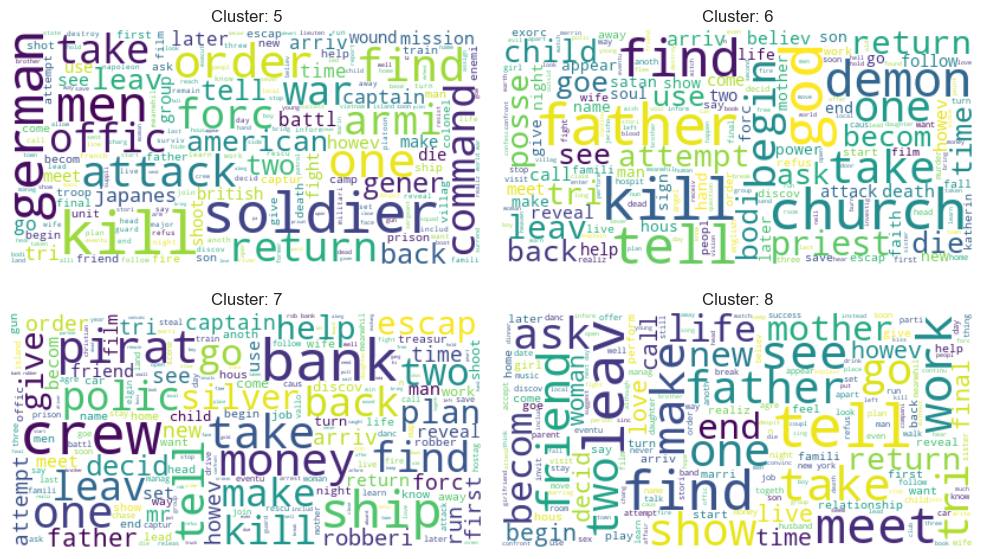

In [1827]:

pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for k in range(5,9):
    ax = axes[(k-5) // 2, (k-5) % 2]

    # Extract data for the current cluster
    s = pic[pic.cluster == k]
    text = s['sum'].str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)

    # Plot the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title('Cluster: {}'.format(k))
    ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.savefig('figures/nlp/word_cloud_example', dpi=1000, bbox_inches='tight')
plt.show()

We see that the 4 cluster seen here have some clear tendencies as well. Looking at Cluster 6 the bigger words, that represent more relevance, seem to fal in the same category with alien, ship, kill and earth as dominant tokens. 

### Top words in each cluster
Now we will try to sort all the words after importance to the clusters.

In [1828]:
def get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer, top_n=10):
    cluster_words = {}
    terms = vectorizer.get_feature_names_out()
    
    for cluster_label in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster_label)[0]
        cluster_tfidf_scores = np.sum(tfidf_matrix[cluster_indices], axis=0)
        sorted_indices = np.argsort(cluster_tfidf_scores)[0, ::-1][:top_n]
        top_words = [terms[i] for i in sorted_indices]
        cluster_words[cluster_label] = top_words
        
    return cluster_words

# Call the function to get cluster words
cluster_words = get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer)

In [1829]:
cluster_words[6][0][0][:10]

array(['god', 'church', 'demon', 'priest', 'father', 'posse', 'exorc',
       'kill', 'faith', 'soul'], dtype=object)

We are again looking at Cluster 6. The most relevant words seem to relate a lot to the titles we saw falling into this cluster. Aliens and space are apparently a theme for this cluster. 

In [1830]:
# Dataframe for top 1000 words ranked for every cluster
cluster_words_ranked = pd.DataFrame()

for i in range(len(cluster_words)):
    cluster_words_ranked[f'{i}'] = cluster_words[i][0][0][:1000]
    
cluster_words_ranked.head(10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,gang,vampir,babi,film,game,soldier,god,bank,love,moor,...,team,bond,town,murder,roman,drug,agent,jake,presid,zombi
1,polic,blood,adopt,life,play,war,church,crew,get,campbel,...,game,largo,sheriff,kill,dewey,dealer,car,find,plane,umbrella
2,kill,kill,child,stori,win,german,demon,pirat,new,ren,...,coach,agent,kill,polic,ghostfac,polic,polic,alonzo,soviet,kill
3,member,lycan,pregnant,love,player,armi,priest,robberi,tell,cole,...,player,kill,small,killer,sidney,kill,fbi,take,bomb,wesker
4,brother,human,parent,relationship,get,japanes,father,ship,relationship,gekko,...,play,escap,men,case,caesar,addict,kill,tell,kill,attack
5,get,coffin,mother,woman,one,command,posse,robber,friend,flint,...,footbal,zorin,cattl,detect,rome,money,money,luck,pilot,survivor
6,train,turn,girl,live,friend,men,exorc,money,leav,hetting,...,win,scaramanga,gold,crime,kill,heroin,smith,brother,unit,reanim
7,gun,attack,year,young,back,kill,kill,rob,woman,danc,...,leagu,soviet,deputi,offic,killer,get,offic,new,agent,escap
8,friend,night,coupl,year,team,american,faith,get,meet,brenner,...,championship,sanchez,brother,investig,murder,find,diamond,want,flight,bitten
9,leader,bite,son,becom,make,camp,soul,polic,show,molli,...,basketbal,submarin,man,man,capot,one,cia,child,aircraft,viru


In [1831]:
cluster_words_ranked.to_csv('nlp/cluster_words.csv', index=False, header=True)

We see that most clusters have themes that are easily identifiable. This makes sense as our method relies on clustering be similar words. 

## Rating & Box Office
In the following section we will try to explore whether there is a significant different in the rating of the different clusters.

In [1832]:
# List with rating and movie ID for movies with more than 20 voters
movie_ratings_boxoffice_cleand = movie_metadata[['TMDB_vote_average', 'Wikipedia Movie ID','log balanced Movie box office revenue']]
movie_ratings_boxoffice_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)
movie_ratings_boxoffice_cleand

/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_40217/3791460451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_ratings_boxoffice_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)


,Rating,ID,log balanced Movie box office revenue
0,5.123,975900,5.998479
1,7.213,171005,6.013946
2,7.571,77856,7.618825
3,7.157,156558,6.320091
4,5.656,25960460,2.679255
...,...,...,...
7558,6.597,1191380,5.229038
7559,6.867,54540,7.487860
7560,4.881,7761830,6.170883
7561,6.327,1918494,5.705871


### Balancing the data

In [1833]:
# Create a DataFrame from the dictionary
movie_id_clusters_df = pd.DataFrame({'ID': movie_ids,'Cluster_Label': cluster_labels})

In [1834]:

# Merge movie_clusters_df with movie_ratings_cleand on the 'id' column
movie_id_clusters_rating_boxoffice_df = pd.merge(movie_id_clusters_df, movie_ratings_boxoffice_cleand, on='ID')
movie_id_clusters_rating_boxoffice_df.head(10)

,ID,Cluster_Label,Rating,log balanced Movie box office revenue
0,31186339,14,7.195,7.576113
1,20663735,14,7.500,4.563201
2,2231378,8,6.700,6.047861
3,595909,23,6.700,5.866737
4,1952976,14,5.630,6.504127
5,18188932,2,6.800,5.256392
6,1480747,4,5.148,6.254840
7,447194,14,6.600,6.764931
8,12978934,13,6.444,6.327801
9,8471210,18,7.457,5.423761


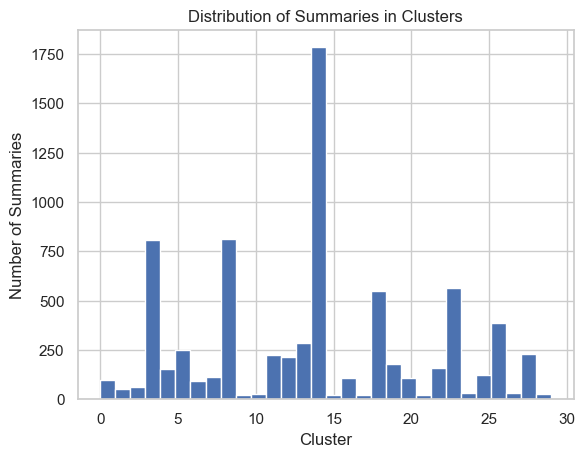

In [1835]:
# Visualize the distribution of clusters
plt.hist(movie_id_clusters_rating_boxoffice_df['Cluster_Label'], bins=num_clusters, align='mid', rwidth=1)
plt.xlabel('Cluster')
plt.ylabel('Number of Summaries')
plt.title('Distribution of Summaries in Clusters')
plt.show()

In [ ]:
# Initialize a DataFrame to store the sampled data
sampled_means = pd.DataFrame()

#samplesize
sample_size = 100

for cluster in movie_id_clusters_rating_boxoffice_df['Cluster_Label'].unique():
    cluster_data = movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]
    
    if len(cluster_data) >= sample_size:
        means_list = []

        for _ in range(100):
            sample = cluster_data.sample(n=sample_size)
            means = sample[['Rating', 'log balanced Movie box office revenue']].mean()
            means_list.append(means)

        means_df = pd.DataFrame(means_list)
        cluster_means = means_df.mean()
        cluster_se = means_df.std() / np.sqrt(len(means_df))
        confidence_interval = 1.96 * cluster_se

        cluster_summary = pd.DataFrame({'Cluster': [cluster], 
                                        'Mean Rating': [cluster_means['Rating']], 
                                        'Rating CI': [confidence_interval['Rating']],
                                        'Mean Revenue': [cluster_means['log balanced Movie box office revenue']],
                                        'Revenue CI': [confidence_interval['log balanced Movie box office revenue']]})
        sampled_means = pd.concat([sampled_means, cluster_summary], ignore_index=True)

# Sort by mean rating and get order of clusters
sorted_indices_rating = sampled_means['Mean Rating'].sort_values().index
sorted_clusters_rating = sampled_means.loc[sorted_indices_rating, 'Cluster']

# Sort by mean revenue and get order of clusters
sorted_indices_revenue = sampled_means['Mean Revenue'].sort_values().index
sorted_clusters_revenue = sampled_means.loc[sorted_indices_revenue, 'Cluster']

# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot for mean rating
axes[0].plot(range(len(sorted_clusters_rating)), sampled_means.loc[sorted_indices_rating, 'Mean Rating'], 'bo-', label='Mean Rating')
axes[0].errorbar(range(len(sorted_clusters_rating)), sampled_means.loc[sorted_indices_rating, 'Mean Rating'], yerr=sampled_means.loc[sorted_indices_rating, 'Rating CI'], fmt='o', color='b')
axes[0].set_xticks(range(len(sorted_clusters_rating)))
axes[0].set_xticklabels(sorted_clusters_rating, rotation=45)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average rating')
axes[0].set_title('Average rating for each cluster')

# Plot for mean revenue
axes[1].plot(range(len(sorted_clusters_revenue)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], 'rx-', label='Mean Revenue')
axes[1].errorbar(range(len(sorted_clusters_revenue)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], yerr=sampled_means.loc[sorted_indices_revenue, 'Revenue CI'], fmt='x', color='r')
axes[1].set_xticks(range(len(sorted_clusters_revenue)))
axes[1].set_xticklabels(sorted_clusters_revenue, rotation=45)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average revenue')
axes[1].set_title('Average revenue for each cluster')

plt.tight_layout()
plt.savefig('figures/nlp/nlp_rev_rating_subplots', dpi=1000, bbox_inches='tight')
plt.show()

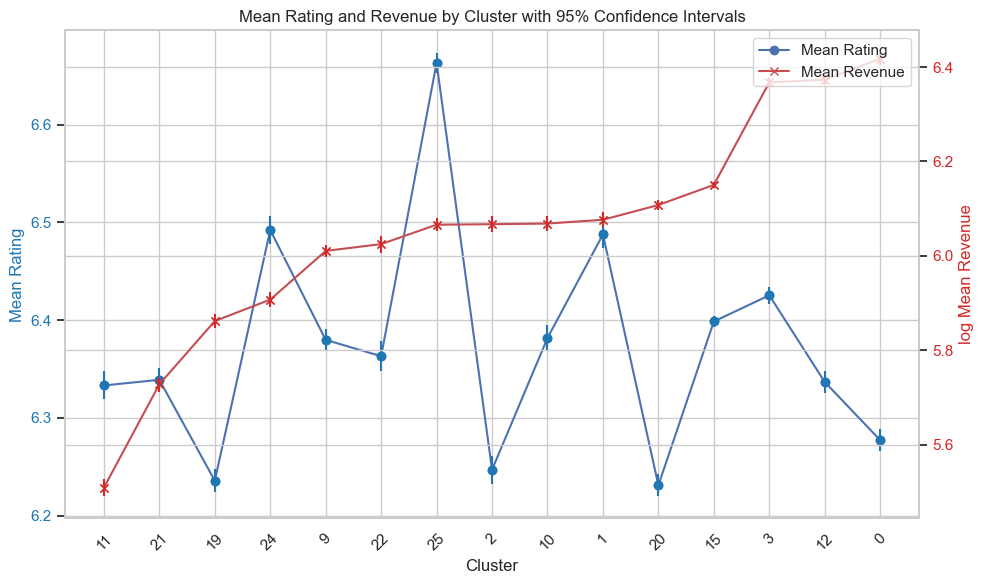

In [98]:

# Sort by mean revenue
sorted_indices_revenue = sampled_means['Mean Revenue'].sort_values().index
sorted_clusters = sampled_means.loc[sorted_indices_revenue, 'Cluster']

# Create a single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting mean rating
color = 'tab:blue'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average rating', color=color)
ax1.plot(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Rating'], 'bo-', label='Mean Rating')
ax1.errorbar(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Rating'], yerr=sampled_means.loc[sorted_indices_revenue, 'Rating CI'], fmt='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a twin Y-axis for mean revenue
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('log Average revenue', color=color)
ax2.plot(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], 'rx-', label='Mean Revenue')
ax2.errorbar(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], yerr=sampled_means.loc[sorted_indices_revenue, 'Revenue CI'], fmt='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis ticks
ax1.set_xticks(range(len(sorted_clusters)))
ax1.set_xticklabels(sorted_clusters, rotation=45)

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

plt.legend(lines, labels, loc='upper right')
plt.title('Average rating and revenue for each cluster')
plt.savefig('figures/nlp/nlp_rev_rating_both_plots', dpi=1000, bbox_inches='tight')
fig.tight_layout() 
plt.show()

In [1838]:
# We need to create a list of ratings and revenues for each cluster to perform ANOVA
clusters = movie_id_clusters_rating_boxoffice_df['Cluster_Label'].unique()
rating_lists = [movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]['Rating'].values for cluster in clusters]
revenue_lists = [movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]['log balanced Movie box office revenue'].values for cluster in clusters]

# Perform ANOVA for Ratings
f_val_rating, p_val_rating = f_oneway(*rating_lists)
print(f'ANOVA test for Ratings: F-value = {f_val_rating}, p-value = {p_val_rating}')

# Perform ANOVA for Revenues
f_val_revenue, p_val_revenue = f_oneway(*revenue_lists)
print(f'ANOVA test for Revenues: F-value = {f_val_revenue}, p-value = {p_val_revenue}')

ANOVA test for Ratings: F-value = 3.8100025195399536, p-value = 2.4183296196784113e-11
ANOVA test for Revenues: F-value = 18.943516163245764, p-value = 1.0912945073999776e-93


ANOVA test for Ratings: F-value = 4.430582716103229, p-value = 2.4550164386549747e-14
ANOVA test for Revenues: F-value = 17.0037665886666, p-value = 7.727915886152203e-83

The results of the ANOVA tests you conducted are highly significant for both ratings and revenues, given the very small p-values:

For ratings, with an F-value of 4.4306 and a p-value of approximately 2.4550164386549747e-14, we reject the null hypothesis that all clusters have the same mean rating. This indicates that there are statistically significant differences in mean ratings among the clusters.

For revenues, with an F-value of 17.0038 and a p-value of approximately 7.727915886152203e-83, we also reject the null hypothesis that all clusters have the same log mean revenue. There are statistically significant differences in log mean revenues among the clusters.

The ANOVA results indicate that there are significant differences in mean box-office revenues across the clusters, and if Cluster 1 (which you've identified as containing all the Western movies) has the highest mean box-office revenue, it means that on average, Western movies in this cluster tend to have higher revenues compared to movies in other clusters.

However, it is important to note that while the average box-office revenue for Western movies in Cluster 1 is higher, this does not guarantee that any given Western movie will have a high box-office revenue. Here are a few reasons why:

Variability Within the Cluster: There is likely to be variability within Cluster 1 itself. Some Western movies may perform very well, while others may not, which could be influenced by factors like the movie's budget, cast, marketing efforts, and release timing, among others.

Statistical Significance vs. Practical Significance: While the difference in means is statistically significant, it is also essential to consider the practical significance of this finding. The extent of the difference between the average revenues of different clusters (effect size) will determine how meaningful this difference is in a real-world context.

External Factors: Box-office success can be influenced by many factors not accounted for in the cluster analysis, such as competition from other movies at the time of release, economic conditions, and changes in consumer preferences.

Historical Data: The analysis is based on historical data. It does not necessarily predict future outcomes, as market dynamics and audience tastes can shift.

Causation vs. Correlation: The analysis shows a correlation between being in Cluster 1 and higher box-office revenues but does not establish a causal relationship. It's not possible to conclude from this analysis alone that being a Western movie causes higher box-office revenue.

In [1866]:
cluster_words[16][0][0][:10]

array(['wed', 'marri', 'mr', 'love', 'monti', 'get', 'tell', 'father',
       'famili', 'marriag'], dtype=object)

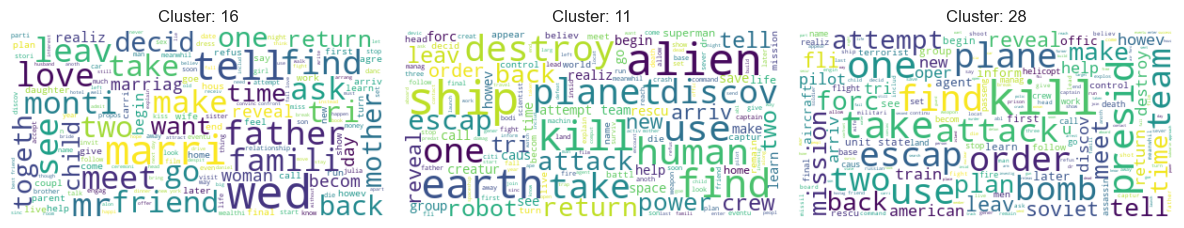

In [1859]:
# World-cloud plotting function
pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

def plot_worldcloud(clusters):
    count = 0
    for k in clusters:
        
        ax = axes[count]
        
        # Extract data for the current cluster
        s = pic[pic.cluster == k]
        text = s['sum'].str.cat(sep=' ')
        
        # Generate word cloud
        wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
        
        # Plot the word cloud
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Cluster: {}'.format(k))
        ax.axis("off")
        
        count += 1

plot_worldcloud([16,11,28])

# Adjust layout
plt.tight_layout()
plt.show()

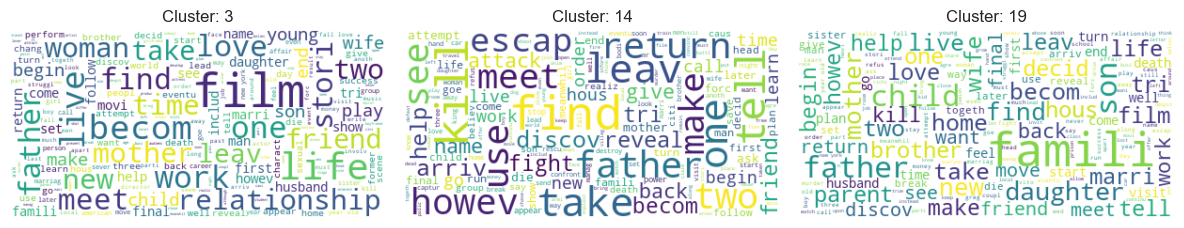

In [1862]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([3,14,19])
# Adjust layout
plt.tight_layout()
plt.show()

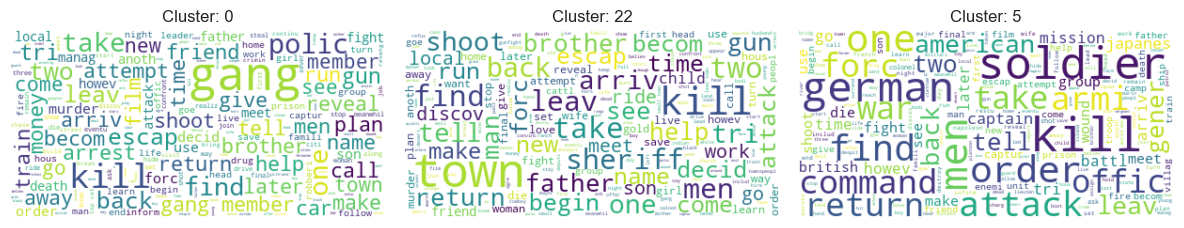

In [1864]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([0,22,5])
# Adjust layout
plt.tight_layout()
plt.show()

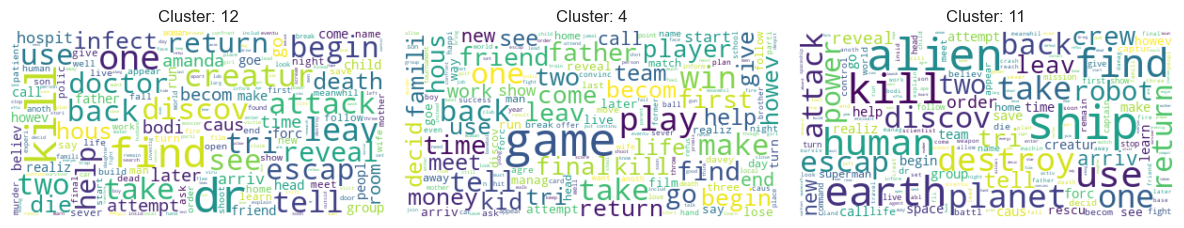

In [1865]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([12,4,11])
# Adjust layout
plt.tight_layout()
plt.show()

In [1844]:
# Calculate the average rating for each cluster
cluster_avg_ratings = movie_id_clusters_rating_boxoffice_df.groupby('Cluster_Label')['Rating'].mean().reset_index()
cluster_std_ratings = movie_id_clusters_rating_boxoffice_df.groupby('Cluster_Label')['Rating'].std().reset_index()

cluster_ratings_avg_std = pd.merge(cluster_avg_ratings, cluster_std_ratings, on='Cluster_Label', suffixes=('_avg', '_std')).sort_values(by='Rating_avg').reset_index(drop=True)

cluster_ratings_avg_std.head(10)

,Cluster_Label,Rating_avg,Rating_std
0,15,5.906500,0.809275
1,10,5.977538,1.091457
2,6,6.043901,0.893191
3,1,6.075396,0.709872
4,29,6.141448,1.028283
5,17,6.175714,0.874579
6,12,6.193273,0.865452
7,4,6.222955,0.858017
8,11,6.232018,0.916696
9,27,6.250176,0.768910
